# Step 4) Monai (Pytorch library), Vector Quantizer Variational Auto Encoder (VQVAE), MNIST
---
In this notebook, we will train a VQVAE from the monai library to represent images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import os
import torch
import torch.nn as nn
import monai
import numpy as np
import torchvision
import matplotlib
import matplotlib.pyplot as plt
###
from monai.data import Dataset as TorchDataset
from monai.data import DataLoader
from monai.transforms import Compose, LoadImage, ToTensor
from monai.networks.nets import VQVAE
###
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchinfo import summary
###
from sklearn.manifold import TSNE
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
###
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4
Monai version: 1.4.0+12.gc1ceea3d


---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

```
Run the two cells below to create DataLoaders for each of the training, validation, and test datasets.
```

In [2]:
# Define a method to Scale the intensity of the input data between minv and maxv
class ScaleIntensity:
    def __init__(self, minv=0.0, maxv=1.0):
        self.minv = minv
        self.maxv = maxv

    def __call__(self, img):
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min)  # Normaliser entre 0 et 1
        img = img * (self.maxv - self.minv) + self.minv  # Rescaler entre minv et maxv
        return img

In [3]:
# how many samples per batch to load
batch_size = 64

# define intensity range for each input data to perform image normalization 
minv = 0    
maxv = 1

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=2),
    ScaleIntensity(minv=minv, maxv=maxv)
])

# Path to store MedNIST dataset
data_dir = "data/MNIST"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# choose the training and test datasets
train_dataset = datasets.MNIST(root='data', train=True, download=download, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=download, transform=transform)

# Split the train_data into a train (80%) and valid (20%) subdataset
train_size = int(0.8 * len(train_dataset))      # 80% for training
valid_size = len(train_dataset) - train_size    # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# Convert data to Dataset MONAI
train_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in train_data], transform=Compose([ToTensor()]))
valid_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in valid_data], transform=Compose([ToTensor()]))
test_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in test_data], transform=Compose([ToTensor()]))

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 12000


### Visualize a Batch of Training Data

It's always important to check the accuracy of the data before going any further.

```
Run the cell below to display a subset of the training dataset and the size of a batch
```

The image batch size is (64, 1, 32, 32)


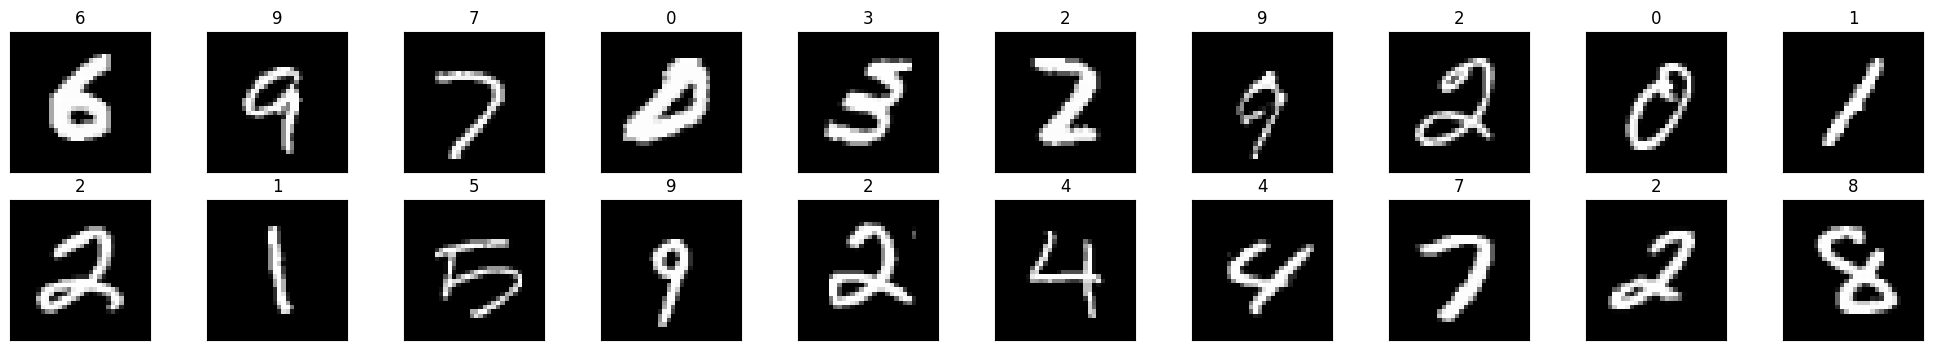

In [4]:
# obtain one batch of training images
dataiter_train = iter(train_loader)
batch = next(dataiter_train)
images, labels = batch["image"], batch["label"]
images = images.numpy()
print(f"The image batch size is {images.shape}")

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

```
Run the cell below to display an image with the value of each pixel. This will enable you to check the operations performed by the transforms.Compose() function.
```

The size of an image from the dataset is (32, 32)


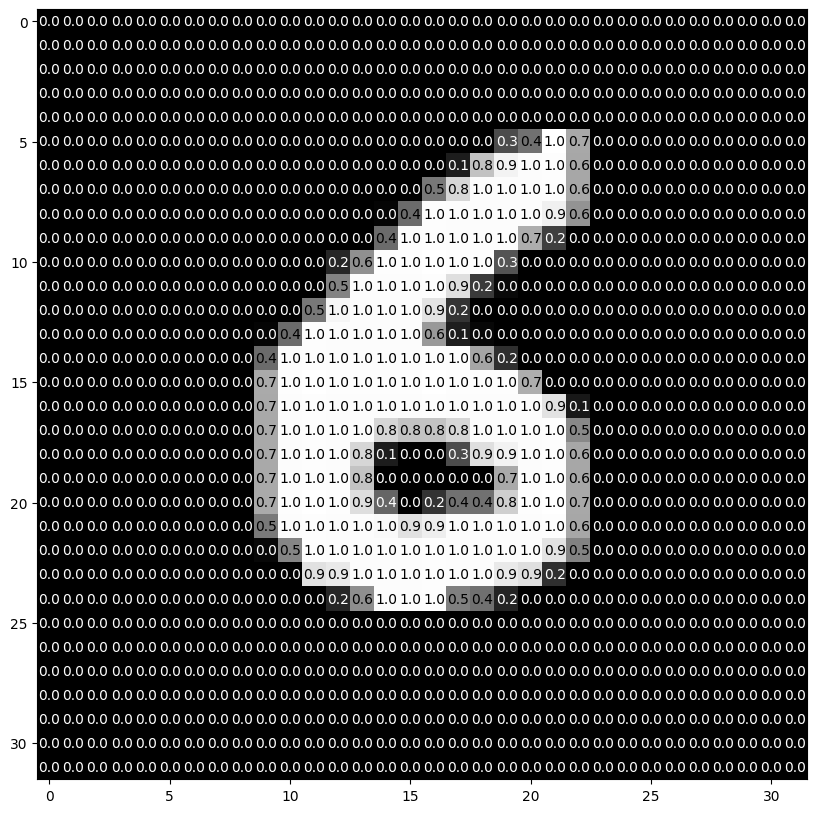

In [5]:
img = np.squeeze(images[0])
print(f"The size of an image from the dataset is {img.shape}")

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The process will be broken down into the following steps:
1. Load and visualize the data
> 2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

```
Run the 3 cells below to define a VQ-VAE network in monai
```

In [6]:
# Parameters
spatial_dims = 2
in_shape = (1, 32, 32)
in_channels = 1
out_channels = 1
latent_size = 2
channels = (16, 32)
num_res_channels = 256
num_res_layers = 2
downsample_parameters = ((2, 4, 1, 1), (2, 4, 1, 1))
upsample_parameters = ((2, 4, 1, 1, 0), (2, 4, 1, 1, 0))
num_embeddings = 256
embedding_dim = 4


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQVAE(
    spatial_dims=spatial_dims,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    num_res_channels=num_res_channels,
    num_res_layers=num_res_layers,
    downsample_parameters=downsample_parameters,
    upsample_parameters=upsample_parameters,
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
).to(device)

In [8]:
# Print the summary of the encoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "num_params"], depth=3, verbose=0
)
summary(model, (1, 1, 32, 32), device="cpu", **summary_kwargs)

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
VQVAE                                         [1, 1, 32, 32]            [1, 1, 32, 32]            --
├─Encoder: 1-1                                [1, 1, 32, 32]            [1, 4, 8, 8]              --
│    └─ModuleList: 2-1                        --                        --                        --
│    │    └─Convolution: 3-1                  [1, 1, 32, 32]            [1, 16, 16, 16]           272
│    │    └─VQVAEResidualUnit: 3-2            [1, 16, 16, 16]           [1, 16, 16, 16]           74,000
│    │    └─VQVAEResidualUnit: 3-3            [1, 16, 16, 16]           [1, 16, 16, 16]           74,000
│    │    └─Convolution: 3-4                  [1, 16, 16, 16]           [1, 32, 8, 8]             8,224
│    │    └─VQVAEResidualUnit: 3-5            [1, 32, 8, 8]             [1, 32, 8, 8]             147,744
│    │    └─VQVAEResidualUnit: 3-6            [1, 32, 8, 8]          

- <span style="color:red">What are the differences between this architecture and that of the VAEs studied in the file 3-monai-vae-mnist ? </span>

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

```
Run the cell below to define the loss function and the optimize scheme
```

In [9]:
## Specify loss and optimization functions
learning_rate = 0.0001
l1_loss = nn.L1Loss()

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

---
## Train the Network

The process will be broken down into the following steps:
1. Load and visualize the data
2. Define a neural network
> 3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

```
Run the cell below to train the network. The following loop trains for 5 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 
```

In [10]:
# Number of epochs to train the model
n_epochs = 5

# Move the model to the device
model = model.to(device)

# Lists to store loss and accuracy for each epoch
train_loss_list = []
valid_metric_list = []
recon_metric_list = []
quant_metric_list = []

best_valid_metric = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    model.train()  # ensure the model is in training mode
    epoch_loss = 0
    recon_val = 0
    quant_val = 0
    
    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        inputs = batch_data["image"].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, quantization_loss = model(images=inputs)
        # calculate the loss
        recon_loss = l1_loss(reconstruction.float(), inputs.float())
        loss = recon_loss + quantization_loss
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        epoch_loss += loss.item() * inputs.size(0)
        recon_val += recon_loss.item() * inputs.size(0)
        quant_val += quantization_loss.item() * inputs.size(0)
        
                
    # Calculate average training loss and accuracy over the epoch
    train_loss_list.append(epoch_loss / len(train_loader.dataset))
    recon_metric_list.append(recon_val / len(train_loader.dataset))
    quant_metric_list.append(quant_val / len(train_loader.dataset))

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_metric = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            inputs = batch_data["image"].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            reconstruction, quantization_loss = model(images=inputs)
            # calculate the loss
            recon_loss = l1_loss(reconstruction.float(), inputs.float())
            valid_metric += recon_loss.item() * inputs.size(0)

    # Compute average validation loss and accuracy
    valid_metric_list.append(valid_metric / len(valid_loader.dataset))
        
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss_list[-1]:.6f} \tValidation metric: {valid_metric_list[-1]:.6f}')

    # Save the model if it has the best validation loss
    if valid_metric_list[-1] < best_valid_metric:
        best_valid_metric = valid_metric_list[-1]
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number
        

# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation metric: {best_valid_metric:.6f}")



Epoch: 1 	Training Loss: 0.073476 	Validation metric: 0.027563
Epoch: 2 	Training Loss: 0.023430 	Validation metric: 0.019921
Epoch: 3 	Training Loss: 0.018926 	Validation metric: 0.017033
Epoch: 4 	Training Loss: 0.016909 	Validation metric: 0.015565
Epoch: 5 	Training Loss: 0.015526 	Validation metric: 0.014755
Best model selected at epoch 5 with validation metric: 0.014755


---
## Evaluate the performance of our trained model on a test dataset

The process will be broken down into the following steps:
1. Load and visualize the data
2. Define a neural network
3. Train the model
> 4. Evaluate the performance of our trained model on a test dataset

```
Run the following cell to display the evolution of the training loss and the validation metric curves to investigate the success of the learning process
```

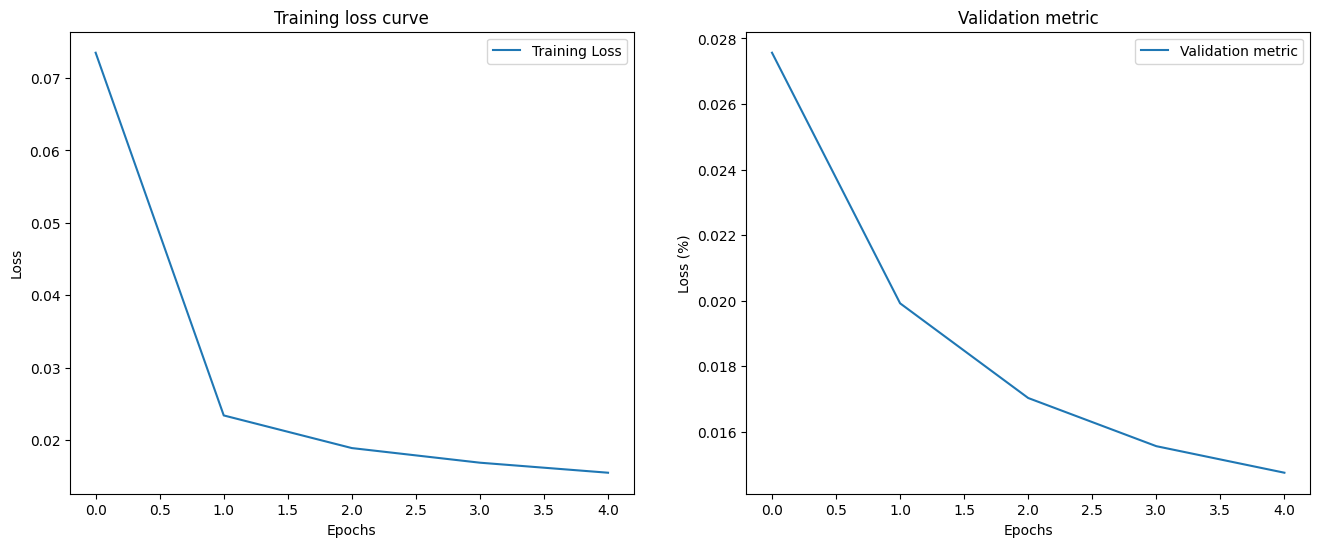

In [21]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation metric
plt.subplot(1, 2, 2)
plt.plot(valid_metric_list, label='Validation metric')
plt.title('Validation metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

- <span style="color:red">What are your conclusions based on the analysis of these two curves ?</span>
- <span style="color:red">Modify the previous code to improve the training process, that is, to achieve better values for the validation metric.</span>

### Display the evolution of the different terms of the loss

```
Run the cell below to investigate the evolution of the different terms of the loss function to analyze the influence of each term
```

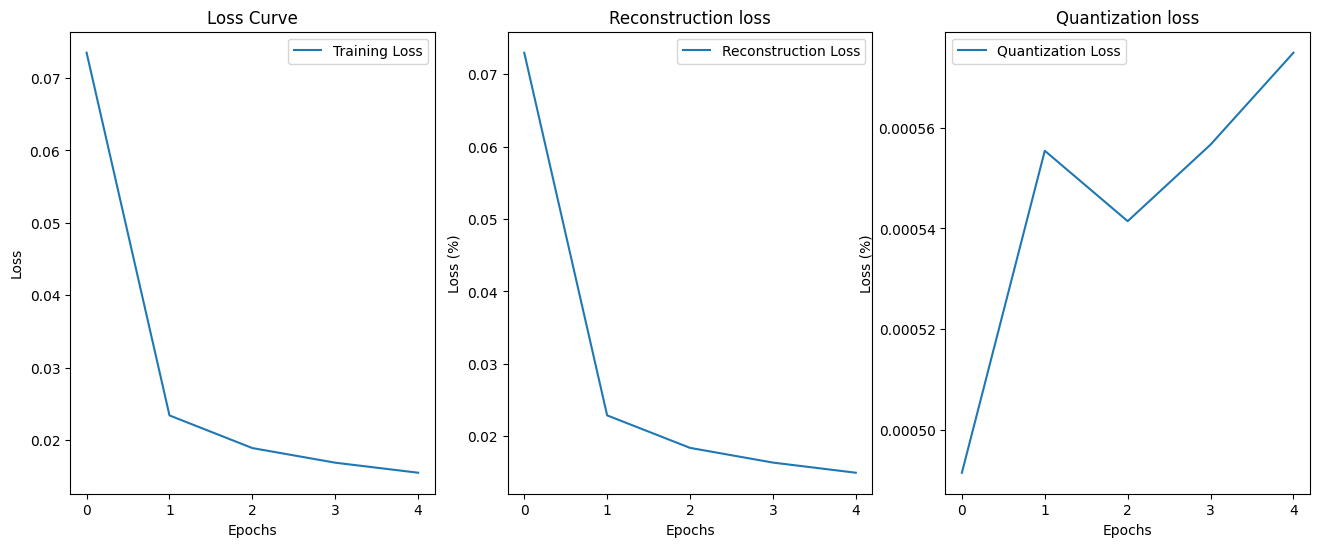

In [11]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Reconstruction loss
plt.subplot(1, 3, 2)
plt.plot(recon_metric_list, label='Reconstruction Loss')
plt.title('Reconstruction loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

# Plotting Qauntization loss
plt.subplot(1, 3, 3)
plt.plot(quant_metric_list, label='Quantization Loss')
plt.title('Quantization loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

- <span style="color:red">Compare the evolution of the three different curves.</span>
- <span style="color:red">Specifically, could you comment on the evolution of the KL metric ?</span>

### Compute the overall performance on the test dataset

We then test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well.

model.eval() will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

```
Run the following cell to compute the scores of the trained network on the test dataset
```

In [12]:
# initialize lists to monitor test loss and accuracy
test_metric = 0.0

model.eval() # prep model for *evaluation*

with torch.no_grad():  # Deactivate the gradient computations
    for batch_data in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        inputs = batch_data["image"].to(device)
        reconstruction, quantization_loss = model(images=inputs)
        # calculate the loss
        recon_loss = l1_loss(reconstruction.float(), inputs.float())
        test_metric += recon_loss.item() * inputs.size(0)    
    
# calculate and print avg test loss
test_metric = test_metric / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_metric))

# Prepare next cell
dataiter = iter(test_loader)

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Test Loss: 0.014755



- <span style="color:red">Compare the scores obtained on the validation data and the test data. Conclusions?</span>

### Visualize Sample Test Results

```
Run the cell below to display reconstructed images taken from the test dataset in the following order: reference image (left) and reconstructed one (right), i.e. the output of the auto-encoder network.
```

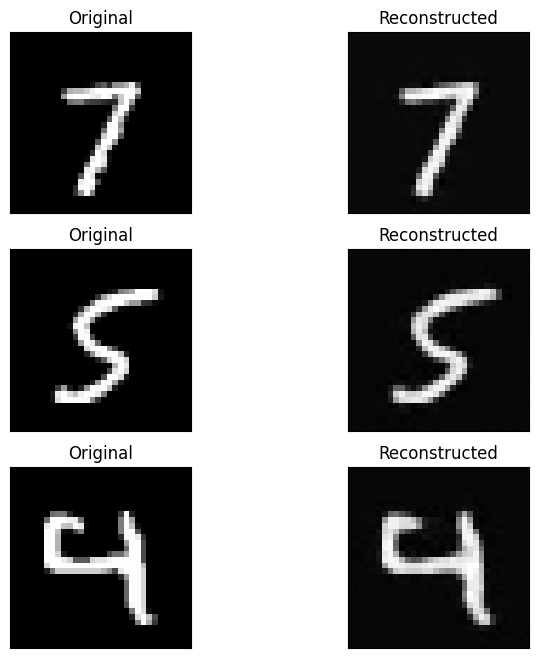

In [13]:
# obtain one batch of test images
batch_data = next(dataiter)

# get sample outputs
inputs = batch_data["image"].to(device)
recons, _ = model(images=inputs)
# reconstruction images for display
recons = recons.detach().cpu().numpy()
inputs = inputs.detach().cpu().numpy()

# Plot the image, label and prediction
fig = plt.figure(figsize=(8, 8))
for idx in range(3):
    ax = fig.add_subplot(3, 2, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]), cmap='gray')
    ax.set_title('Original')
    ax = fig.add_subplot(3, 2, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(np.squeeze(recons[idx]), cmap='gray')
    ax.set_title('Reconstructed')

- <span style="color:red">Can you comment on the difference in reconstruction quality compared to the results obtained with the previous Jupyter notebooks ?</span>
- <span style="color:red">In your opinion, what factors contributed to this quality of results ?</span>

### Visualize the embedding (dictionnary) vectors

```
Run the following cell to display the values of each dictionary vectors, component by component.
```

Embedding size (256, 4)


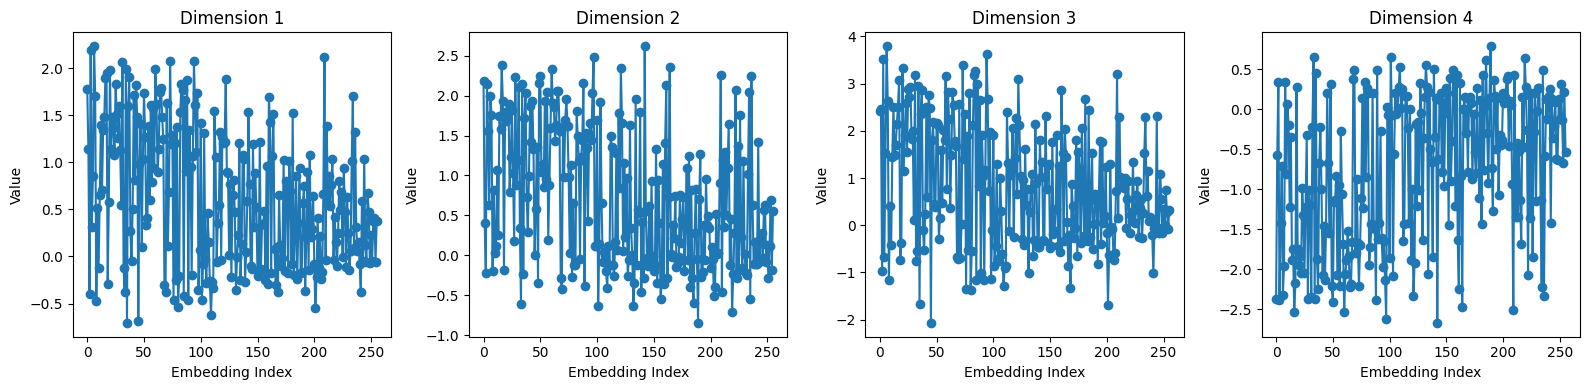

In [14]:
embeddings = model.state_dict()["quantizer.quantizer.embedding.weight"]
embeddings_np = embeddings.detach().cpu().numpy()
print(f"Embedding size {embeddings_np.shape}")

# Display the values for each of the 4th dimensions for each 256 embedding vectors
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].plot(embeddings_np[:, i], marker='o')
    axes[i].set_title(f"Dimension {i+1}")
    axes[i].set_xlabel("Embedding Index")
    axes[i].set_ylabel("Value")
plt.tight_layout()
plt.show()

- <span style="color:red">What conclusions can you draw from it ?</span>

### Visualize latent space thanks to t-SNE

It can be useful to visualize the latent space to study its structure. Since the dimensions of the latent space are not in 2D, we use a more sophisticated method, called t-SNE, to perform this visualization.

```
Run the 2 cells below to compute and display the latent space
```

In [23]:
downsampling_ratio = 5
counter = 0  # counter initialisation

model.eval() # prep model for *evaluation*
encoder_accumulated = []
quantization_accumulated = []
labels_accumulated = []

with torch.no_grad():  # Deactivate the gradient computations
    for batch_data in test_loader:
        counter += 1
        if counter % downsampling_ratio == 0:
            # forward pass: compute predicted outputs by passing inputs to the model
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            z = model.encode(inputs)
            q, _ = model.quantize(z)
            encoder_accumulated.append(z.cpu().numpy())
            quantization_accumulated.append(q.cpu().numpy())
            labels_accumulated.append(labels.cpu().numpy())
    
encoder_accumulated = np.concatenate(encoder_accumulated, axis=0)
quantization_accumulated = np.concatenate(quantization_accumulated, axis=0)
labels_accumulated = np.concatenate(labels_accumulated, axis=0)
encoder_flattened = encoder_accumulated.reshape(encoder_accumulated.shape[0], -1)
quantization_flattened = quantization_accumulated.reshape(quantization_accumulated.shape[0], -1)
print(f"Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = {encoder_flattened.shape}")

# Apply t-SNE to reduce the dimensionality to 2 and allows a visualization of the latent space
tsne1 = TSNE(n_components=2, random_state=42)
encoder_tsne = tsne1.fit_transform(encoder_flattened)
tsne2 = TSNE(n_components=2, random_state=42)
quantization_tsne = tsne2.fit_transform(quantization_flattened)


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = (2368, 256)


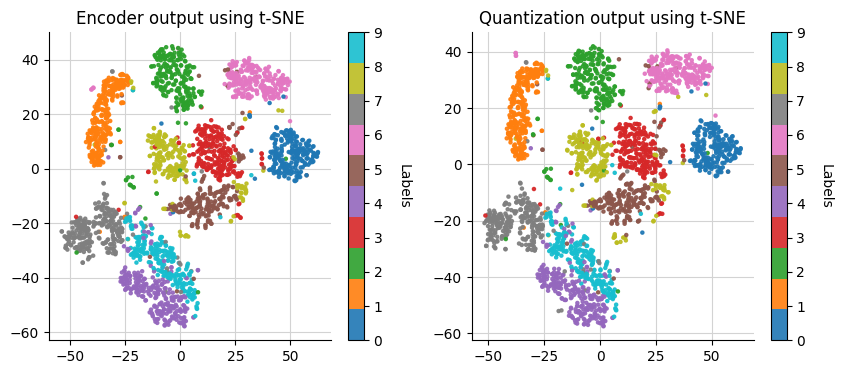

In [16]:
show_grid = True

fig = plt.figure(figsize=(10, 14) if not show_grid else (10, 4))

# create a scatter plot of the embeddings, colored by the labels
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(
    x=encoder_tsne[:, 0], 
    y=encoder_tsne[:, 1], 
    c=labels_accumulated, 
    cmap="tab10", 
    s=5, 
    alpha=0.9,
    zorder=2,
    )

# remove the top and right spines from the plot
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Encoder output using t-SNE")
# add a colorbar to the plot
cbar = plt.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
# if show is True, display the plot
if show_grid:
    # add a grid to the plot
    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    # plt.show()
# otherwise, save the plot to a file and close the figure
else:
    plt.savefig("latent_space.png", bbox_inches="tight")
    plt.close()
    

# create a scatter plot of the embeddings, colored by the labels
ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(
    x=quantization_tsne[:, 0], 
    y=quantization_tsne[:, 1], 
    c=labels_accumulated, 
    cmap="tab10", 
    s=5, 
    alpha=0.9,
    zorder=2,
    )

# remove the top and right spines from the plot
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Quantization output using t-SNE")
# add a colorbar to the plot
cbar = plt.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
# if show is True, display the plot
if show_grid:
    # add a grid to the plot
    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    # plt.show()
# otherwise, save the plot to a file and close the figure
else:
    plt.savefig("latent_space.png", bbox_inches="tight")
    plt.close()

- <span style="color:red">What does the size of the latent matrix passed to the t-SNE method correspond to ?</span>
- <span style="color:red">What is the difference between the variables encoder_flattened and quantization_flattened ?</span>
- <span style="color:red">What is the size of the matrix generated by the the t-SNE method ?</span>
- <span style="color:red">Analyze and interpret the two latent spaces obtained ?</span>

### Plot random images

Now it is time to test the capacity of generating new synthetic digits. This is done in two steps:
1) samples directly from the latent space;
2) use the decoder to project the sample into the image space to generate the synthetic image.

```
Run the cell below to compute and display the latent space from a grid of points sampled directed from the latent space
```

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


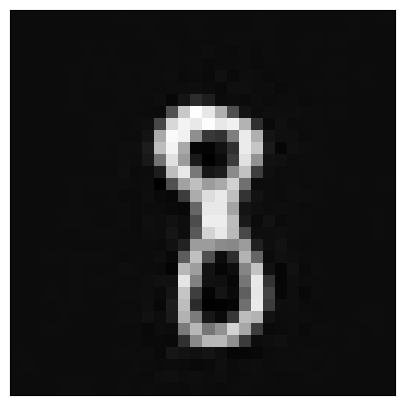

In [17]:
random_generation = False

if random_generation:
    latent_mat = torch.randn(1, 4, 8, 8).to(device)
else:
    inputs = batch_data["image"].to(device)
    input = inputs[0]
    input = input.unsqueeze(0)
    latent_mat = model.encode(images=input)

# Quantization of the latent sample
quantized_latent, _ = model.quantize(latent_mat)

# Decode the quantization sample
synthetic_image = model.decode(quantized_latent)
img = synthetic_image.squeeze().detach().cpu().numpy()
img = np.squeeze(img)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111, xticks=[], yticks=[])
ax.imshow(img, cmap='gray')


### Let's create a cool animation ;)

```
Run the three cells below to generate an animation that allows you to study the properties of latent space. 
```

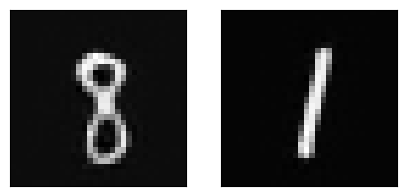

In [18]:
# Randomly select two points in the latent space
inputs = batch_data["image"].to(device)
input = inputs[0]
input = input.unsqueeze(0)
latent_1 = model.encode(images=input)
input = inputs[1]
input = input.unsqueeze(0)
latent_2 = model.encode(images=input)

# Quantization of the two latent samples
quant_1, _ = model.quantize(latent_1)
quant_2, _ = model.quantize(latent_2)
synthetic_1 = model.decode(quant_1)
synthetic_2 = model.decode(quant_2)

img_1 = synthetic_1.squeeze().detach().cpu().numpy()
img_1 = np.squeeze(img_1)
img_2 = synthetic_2.squeeze().detach().cpu().numpy()
img_2 = np.squeeze(img_2)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
ax.imshow(img_1, cmap='gray')
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
ax.imshow(img_2, cmap='gray')


In [24]:
def interpolate_images(model, latent_1, latent_2, steps=10):
    # Interpolate between point1 and point2 in the latent space
    
    latent_1.to(device)
    latent_2.to(device)
    t_values = torch.linspace(0, 1, steps).to(device)    
    latent_tmp = [torch.lerp(latent_1, latent_2, t).to(device) for t in t_values]
    latent_interp = torch.stack([latent.squeeze(0) for latent in latent_tmp], dim=0)
    quantizers_interp, _ = model.quantize(latent_interp)
    synthetic_interp = model.decode(quantizers_interp)
    
    # Return images as a list after detaching and converting to numpy
    return [img.squeeze().detach().cpu().numpy() for img in synthetic_interp]

def save_animation_as_gif(images, filename="animation.gif", interval=200):
    fig, ax = plt.subplots(figsize = (4,4))
    img_display = ax.imshow(images[0], cmap="gray", vmin=0, vmax=1)
    ax.axis("off")

    def update(frame):
        img_display.set_data(images[frame])
        return [img_display]

    ani = FuncAnimation(fig, update, frames=len(images), interval=interval, blit=True)
    ani.save(filename, writer="pillow", fps=1000//interval)
    plt.close(fig) 


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


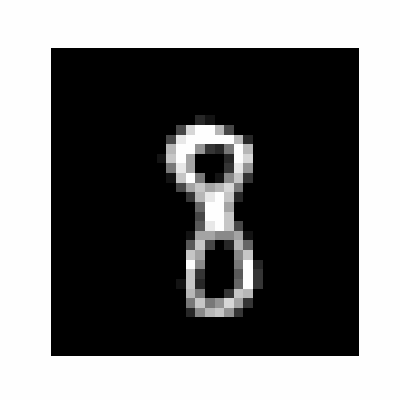

In [25]:
# Interpolate between the two points and decode to generate images
images = interpolate_images(model, latent_1, latent_2, steps=64)

# Animate the interpolated images
filename = "mnist_interpolation.gif"
save_animation_as_gif(images, filename=filename, interval=100)

# Affiche le GIF dans Jupyter
display(Image(filename=filename))   

---
## Additional questions

Now that you have mastered this first code, try experimenting with the properties of the network to study their influence on the quality of the results

- <span style="color:red">Evaluate the influence of the netwrok architecture. Try for instance to modify the number of layers (through channels), the latent_size or the number of embedding vectors (num_embeddings). Be careful with the number of associated parameters so that the model to train is not too large.</span>